# Section 1: Environment Setup (Local PySpark Setup)

## Step 1: Environment Setup

In [2]:
from pyspark.sql import SparkSession

def create_spark_session():
    spark = SparkSession.builder \
        .appName("Traffic Crashes Severity Prediction") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .config("spark.hadoop.hadoop.native.lib", "false") \
        .config("spark.sql.parquet.enableVectorizedReader", "false") \
        .getOrCreate()
    return spark

spark = create_spark_session()

print(spark.version)

3.5.5


## Step 2: Loading CSV, Quick Schema and Row Count Check (small EDA) 

In [3]:
# Load DataFrames from Local Filesystem
crashes = spark.read.option("header", True).csv(r"Traffic_Crashes_Crashes.csv")
vehicles = spark.read.option("header", True).csv(r"Traffic_Crashes_People.csv")
people = spark.read.option("header", True).csv(r"Traffic_Crashes_Vehicles.csv")

# Quick schema validation
crashes.printSchema()
vehicles.printSchema()
people.printSchema()

# Check row counts
print(f"Crashes: {crashes.count()} rows")
print(f"Vehicles: {vehicles.count()} rows")
print(f"People: {people.count()} rows")

root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: string (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: string (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_CO

# Section 2: Joining Datasets

## Step 1: Join the Datasets

Before joining, we need to rename or drop duplicate columns like CRASH_DATE from vehicles_df and people_df, because:

- crashes_df has the most accurate crash-level date

- vehicle and people versions are mostly redundant for our big-picture analysis

In [4]:
# Step 1: Drop CRASH_DATE from vehicles and people BEFORE join
vehicles_df = vehicles.drop("CRASH_DATE")
people_df = people.drop("CRASH_DATE")

# Step 2: Join Crashes and Vehicles
crash_vehicle_df = crashes.join(
    vehicles_df,
    on="CRASH_RECORD_ID",
    how="inner"
)

# Step 3: Join Crash-Vehicle with People
final_df = crash_vehicle_df.join(
    people_df,
    on=["CRASH_RECORD_ID", "VEHICLE_ID"],
    how="left"
)

# Step 4: Show sample
final_df.select(
    "CRASH_RECORD_ID", "CRASH_DATE", "CRASH_TYPE", 
    "VEHICLE_TYPE", "PERSON_TYPE", "INJURY_CLASSIFICATION"
).show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------+---------------------------+-----------+-----------------------+
|CRASH_RECORD_ID                                                                                                                 |CRASH_DATE            |CRASH_TYPE            |VEHICLE_TYPE               |PERSON_TYPE|INJURY_CLASSIFICATION  |
+--------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------+---------------------------+-----------+-----------------------+
|00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379|04/16/2016 05:49:00 AM|NO INJURY / DRIVE AWAY|SPORT UTILITY VEHICLE (SUV)|DRIVER     |NO INDICATION OF INJURY|
|000070ed7a6357c3298f5edc6fb7d5ce925

# Section 3: Primary EDA (Exploratory Data Analysis)

## Step 1: Quick Data Overview

In [5]:
# Show sample
final_df.show(5)

# Show schema
final_df.printSchema()

# Count number of rows and columns
row_count = final_df.count()
col_count = len(final_df.columns)

print(f"Total Rows: {row_count}")
print(f"Total Columns: {col_count}")

+--------------------+----------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+--------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+-------------+--------------+--------------------+---------+-----------+-------+--------+-----+-------+---+----+---------------------+---------------------+--------------

### Primary EDA Analysis Summary

Dataset Status:

- Total Rows: 2,060,623
- Total Columns: 143
- Source Tables Joined: Crashes + Vehicles + People

## Step 2: Null Value Analysis

In [6]:
from pyspark.sql.functions import col, sum as spark_sum, when

# Calculate missing values per column
missing_counts = final_df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in final_df.columns
])

missing_counts.show(vertical=True, truncate=False)

-RECORD 0--------------------------------
 CRASH_RECORD_ID               | 0       
 VEHICLE_ID                    | 42261   
 CRASH_DATE_EST_I              | 1946350 
 CRASH_DATE                    | 0       
 POSTED_SPEED_LIMIT            | 0       
 TRAFFIC_CONTROL_DEVICE        | 0       
 DEVICE_CONDITION              | 0       
 WEATHER_CONDITION             | 0       
 LIGHTING_CONDITION            | 0       
 FIRST_CRASH_TYPE              | 0       
 TRAFFICWAY_TYPE               | 0       
 LANE_CNT                      | 1614145 
 ALIGNMENT                     | 0       
 ROADWAY_SURFACE_COND          | 0       
 ROAD_DEFECT                   | 0       
 REPORT_TYPE                   | 78615   
 CRASH_TYPE                    | 0       
 INTERSECTION_RELATED_I        | 1492604 
 NOT_RIGHT_OF_WAY_I            | 1988568 
 HIT_AND_RUN_I                 | 1495849 
 DAMAGE                        | 0       
 DATE_POLICE_NOTIFIED          | 0       
 PRIM_CONTRIBUTORY_CAUSE       | 0

### Key Observations from Missing Value Analysis

1. Good Columns (Almost No Missing Values)

✅ These columns are mostly complete:

- `CRASH_RECORD_ID`
- `CRASH_DATE`
- `POSTED_SPEED_LIMIT`
- `TRAFFIC_CONTROL_DEVICE`
- `DEVICE_CONDITION`
- `WEATHER_CONDITION`
- `LIGHTING_CONDITION`
- `FIRST_CRASH_TYPE`
- `CRASH_TYPE`
- `ROADWAY_SURFACE_COND`
- `PRIM_CONTRIBUTORY_CAUSE`
- `SEC_CONTRIBUTORY_CAUSE`
- `INJURIES_TOTAL`, `INJURIES_FATAL`, `INJURIES_NO_INDICATION`, `INJURIES_INCAPACITATING`, `INJURIES_NON_INCAPACITATING`, `INJURIES_REPORTED_NOT_EVIDENT`, `INJURIES_UNKNOWN`
- `CRASH_HOUR`, `CRASH_DAY_OF_WEEK`, `CRASH_MONTH`

➡️ These columns are high-quality candidates for modeling without heavy imputation.

---

2. Columns with Massive Missing Values (>90% missing)

🚫 These columns are almost useless unless we carefully fill or engineer them:

- `CRASH_DATE_EST_I`
- `INTERSECTION_RELATED_I`
- `NOT_RIGHT_OF_WAY_I`
- `HIT_AND_RUN_I`
- `TOWED_I`
- `WORK_ZONE_I`, `WORK_ZONE_TYPE`, `WORKERS_PRESENT_I`
- `AREA_00_I` to `AREA_12_I`, `AREA_99_I`
- `PEDPEDAL_ACTION`, `PEDPEDAL_VISIBILITY`, `PEDPEDAL_LOCATION`
- `EMS_AGENCY`, `EMS_RUN_NO`
- `BAC_RESULT VALUE`
- `HAZMAT_PLACARDS_I`, `HAZMAT_NAME`, `UN_NO`, `HAZMAT_PRESENT_I`, `HAZMAT_REPORT_I`
- `WIDE_LOAD_I`
- `MCS_*` related columns
- `IDOT_PERMIT_NO`, `GVWR`, `CARRIER_NAME`, `CARRIER_CITY`, `CARRIER_STATE`

➡️ We can **safely DROP** most of these columns to reduce noise and improve modeling performance.

---

3. Person Data Is Very Sparse

🧍 Person-related fields like:

- `PERSON_ID`
- `SEX`
- `AGE`
- `CITY`, `STATE`, `ZIPCODE`
- `SAFETY_EQUIPMENT`
- `AIRBAG_DEPLOYED`
- `INJURY_CLASSIFICATION`
- `DRIVERS_LICENSE_STATE`, `DRIVERS_LICENSE_CLASS`
- `BAC_RESULT`
- `CELL_PHONE_USE`
- `EMS_*`

have significant missingness, often between **30% to 90%**, especially in pedestrian and cyclist records.

➡️ For modeling, it's safer to either:
- **Separate** person-level data into a specialized analysis/model, or
- **Exclude** it initially to keep the crash-level modeling clean and consistent.

---

 Overall Strategy

- ✅ Focus on clean crash and vehicle attributes.
- 🚫 Drop highly missing, unreliable, or niche columns.
- ⚙️ Consider filling essential columns with careful logic only if needed.


## Step 3: Feature Shortlisting

🧠 Feature Shortlisting Strategy

We’ve categorized features into three clear groups for better modeling clarity based on missingness and relevance.

---

 🎯 Target Columns (Modeling Outcomes)

| Column               | Type               | Reason |
|----------------------|--------------------|--------|
| `INJURIES_TOTAL`      | Regression         | Predicts total number of injuries in a crash — good for severity/cost modeling. |
| `INJURIES_FATAL`      | Regression / Binary | Can be framed as binary classification: fatal vs non-fatal. |
| `MOST_SEVERE_INJURY`  | Classification     | Categorical outcome — great for multi-class classification (e.g., NO INJURY, FATAL, SERIOUS INJURY, etc.). |

💡 **We can pick any of the three depending on our modeling direction.**  
(We'll finalize this after further EDA on outcome distributions.)

---

 ✅ Selected Input Features (Predictors)

| Feature                   | Type         | Why |
|----------------------------|--------------|-----|
| `CRASH_TYPE`               | Categorical  | Overall type of crash: rear-end, sideswipe, collision with object, etc. |
| `FIRST_CRASH_TYPE`         | Categorical  | More granular first-event crash type. |
| `POSTED_SPEED_LIMIT`       | Numeric      | Environmental risk factor (speed). |
| `TRAFFIC_CONTROL_DEVICE`   | Categorical  | Presence of stop signs, traffic lights, yield signs. |
| `DEVICE_CONDITION`         | Categorical  | Whether traffic controls were working properly. |
| `WEATHER_CONDITION`        | Categorical  | Impact of rain, snow, fog, etc. on crashes. |
| `LIGHTING_CONDITION`       | Categorical  | Daylight, dark streetlight conditions. |
| `ROADWAY_SURFACE_COND`     | Categorical  | Road condition at time of crash (dry, wet, icy). |
| `PRIM_CONTRIBUTORY_CAUSE`  | Categorical  | Main cause of crash (e.g., speeding, distraction). |
| `SEC_CONTRIBUTORY_CAUSE`   | Categorical  | Secondary contributing factor. |
| `CRASH_HOUR`, `CRASH_DAY_OF_WEEK`, `CRASH_MONTH` | Numeric | Temporal patterns (rush hours, weekdays vs weekends, seasonal effects). |
| `VEHICLE_TYPE`             | Categorical  | Car, SUV, Truck, Bicycle, etc. |
| `MANEUVER`                 | Categorical  | Turning, going straight, changing lanes — vehicle movement just before crash. |

✅ **These columns are relatively complete** and capture important contextual, environmental, and behavioral signals for modeling injury outcomes.

---

 🗑️ Features to Drop (Too Sparse or Irrelevant)

| Reason                  | Examples |
|--------------------------|----------|
| 🚫 **90%+ Missing Values** | `CRASH_DATE_EST_I`, `INTERSECTION_RELATED_I`, `NOT_RIGHT_OF_WAY_I`, `HIT_AND_RUN_I`, `TOWED_I`, `WORK_ZONE_I`, `AREA_XX_I`, `HAZMAT_*` related fields, `EMS_RUN_NO`, etc. |
| 📉 **Sparse Person Fields** | `EMS_AGENCY`, `PEDPEDAL_ACTION`, `BAC_RESULT VALUE`, `DRIVERS_LICENSE_CLASS`, etc. (especially pedestrian/bicyclist-specific fields). |
| 🔁 **Redundant/Highly Specific** | `STREET_NO`, `STREET_DIRECTION`, `STREET_NAME`, `LOCATION` (very fine-grained, too geolocation-specific for generalized modeling). |

➡️ **We will exclude these from the modeling dataset** to keep it clean, compact, and memory-efficient.

---

 📌 Final Next Step:
Proceed to clean the DataFrame by:
- Keeping only the selected predictors and target(s).
- Dropping sparse, noisy, or redundant columns.
- Preparing feature transformations for modeling (indexing, encoding, assembling features).


## Step 4: Create Cleaned Feature Dataset

In [7]:
# Choose selected columns
selected_columns = [
    "INJURIES_TOTAL", "INJURIES_FATAL", "MOST_SEVERE_INJURY",
    "CRASH_TYPE", "FIRST_CRASH_TYPE", "POSTED_SPEED_LIMIT",
    "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION",
    "LIGHTING_CONDITION", "ROADWAY_SURFACE_COND", "PRIM_CONTRIBUTORY_CAUSE",
    "SEC_CONTRIBUTORY_CAUSE", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH",
    "VEHICLE_TYPE", "MANEUVER"
]

# Filter the full DataFrame to only include selected columns
model_df = final_df.select(*selected_columns)

# Preview it
model_df.show(5)

+--------------+--------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+-----------------------+----------------------+----------+-----------------+-----------+--------------------+--------------------+
|INJURIES_TOTAL|INJURIES_FATAL|  MOST_SEVERE_INJURY|          CRASH_TYPE|    FIRST_CRASH_TYPE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|    DEVICE_CONDITION|WEATHER_CONDITION|  LIGHTING_CONDITION|ROADWAY_SURFACE_COND|PRIM_CONTRIBUTORY_CAUSE|SEC_CONTRIBUTORY_CAUSE|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|        VEHICLE_TYPE|            MANEUVER|
+--------------+--------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+-----------------------+----------------------+----------+-----------------+-----------

# Section 5: Final EDA & Modeling Direction

## Step 1: Quick Class Distribution of MOST_SEVERE_INJURY

In [8]:
model_df.groupBy("MOST_SEVERE_INJURY").count().orderBy("count", ascending=False).show(truncate=False)

+------------------------+-------+
|MOST_SEVERE_INJURY      |count  |
+------------------------+-------+
|NO INDICATION OF INJURY |1690133|
|NONINCAPACITATING INJURY|204207 |
|REPORTED, NOT EVIDENT   |120663 |
|INCAPACITATING INJURY   |42758  |
|FATAL                   |2848   |
|NULL                    |14     |
+------------------------+-------+



### Interpretation of Class Distribution: `MOST_SEVERE_INJURY`

 📊 Step 1: MOST_SEVERE_INJURY Class Distribution

| Class                    | Count   | % of Total |
|--------------------------|---------|------------|
| NO INDICATION OF INJURY  | 1,690,133 | ~82.6%     |
| NONINCAPACITATING INJURY | 204,207   | ~10.0%     |
| REPORTED, NOT EVIDENT    | 120,663   | ~5.9%      |
| INCAPACITATING INJURY    | 42,758    | ~2.1%      |
| FATAL                    | 2,848     | ~0.14%     |
| NULL (missing values)    | 14        | ~0.0007%   |

---

 ✅ Key Observations:

- 📉 **Severe Class Imbalance**:  
  The majority of crashes (~83%) resulted in **no injuries**, which can heavily skew model training if not handled.

- ⚠️ **Low Representation of Critical Classes**:  
  Only ~0.14% of records are **fatal** crashes. Models might struggle to learn these minority classes unless special handling (resampling, weighting) is used.

- 🧹 **Minimal Missing Labels**:  
  Only 14 rows have NULL in the target — these can be **safely dropped** without affecting data quality.

---

 🔧 Modeling Implications:

- Consider **class balancing strategies** such as:
  - Class weighting
  - Undersampling "No Injury"
  - Oversampling rare injuries

- Or, merge classes to reduce imbalance:
  - **FATAL + INCAPACITATING → SEVERE_INJURY**
  - **REPORTED/NOT EVIDENT + NONINCAPACITATING → MINOR_INJURY**
  - **NO INDICATION → NO_INJURY**

➡️ This creates a more balanced **3-class setup**:  
`SEVERE`, `MINOR`, and `NO_INJURY` — easier to train and interpret.

## Step 2: Distribution of INJURIES_TOTAL

In [9]:
from pyspark.sql.functions import col

# Descriptive stats
model_df.select("INJURIES_TOTAL").describe().show()

# Cast INJURIES_TOTAL to integer
model_df = model_df.withColumn("INJURIES_TOTAL", col("INJURIES_TOTAL").cast("int"))

# Now we can safely compute quantiles
quantiles = model_df.approxQuantile("INJURIES_TOTAL", [0.5, 0.9, 0.99], 0.01)
print(f"Median: {quantiles[0]}, 90th percentile: {quantiles[1]}, 99th percentile: {quantiles[2]}")

+-------+-------------------+
|summary|     INJURIES_TOTAL|
+-------+-------------------+
|  count|            2060623|
|   mean|0.28866609758310957|
| stddev| 0.7960497159240851|
|    min|                  0|
|    max|                  9|
+-------+-------------------+

Median: 0.0, 90th percentile: 1.0, 99th percentile: 21.0


### Interpretation of the Results

 ✅ Key Observations:

- ⚠️ **Highly skewed** distribution:
  - The **median is 0**, indicating that **most crashes result in no injuries**.
  - The average is just ~0.29, confirming that the distribution is heavily right-skewed.

- 🚨 **Rare but extreme outliers**:
  - While 90% of crashes have **1 or fewer injuries**, the top 1% involve up to **21 people injured**.
  - These rare, high-impact crashes can distort model performance if not handled carefully.

- 📉 **Modeling impact**:
  - If we model `INJURIES_TOTAL` as a regression problem, it will be **imbalanced** and dominated by the zeros.
  - A simple linear regression would struggle — we may need:
    - Log-transformation (for reducing skew),
    - Robust regression,
    - Or even reframing as a **classification task** (e.g., No Injury vs. Any Injury).


## Step 3: Modeling Direction Summary

 🎯 Research Question

Can we predict the **most severe injury outcome** of a traffic crash based on **crash conditions**, **vehicle types**, **environmental factors**, and **crash timing**?

---

 📋 Modeling Pathways

| Direction                  | Target Variable        | Method(s)                                          | Rationale |
|----------------------------|------------------------|----------------------------------------------------|-----------|
| ✅ Multi-class Classification (Preferred) | `MOST_SEVERE_INJURY`     | Logistic Regression, Decision Tree, Random Forest, GBTClassifier | Classes are interpretable (No Injury, Minor, Severe, Fatal); imbalance is manageable after class grouping. |
| 🔵 Binary Classification (Optional)       | `INJURIES_FATAL`          | Logistic Regression, Tree Models                   | Important for policy planning, but extreme imbalance (~0.14%) makes it tricky without resampling. |
| 🔴 Regression (Not Preferred)             | `INJURIES_TOTAL`          | Linear Regression, GBT Regressor                   | Highly skewed — most crashes have 0 injuries, top 1% skew results; difficult to generalize. |

---

 📌 Final Recommendation

- ✅ **Proceed with Multi-Class Classification** using `MOST_SEVERE_INJURY`.
- 🧹 Drop rows where `MOST_SEVERE_INJURY` is **NULL** (only 14 rows — negligible).
- 🔄 (Optional) **Group rare classes** for a simpler, more balanced target:
  - `FATAL` + `INCAPACITATING` → **SEVERE_INJURY**
  - `NONINCAPACITATING` + `REPORTED, NOT EVIDENT` → **MINOR_INJURY**
  - `NO INDICATION OF INJURY` → **NO_INJURY**

➡️ This creates a **3-class classification task** that improves balance while preserving meaning.

---

 📋 Final Selected Models

| Model                    | Reason |
|--------------------------|--------|
| Logistic Regression      | Good baseline; interpretable coefficients. |
| Decision Tree Classifier | Understand rule-based splits causing injuries. |
| Random Forest Classifier | Higher accuracy; robust to noise. |
| GBTClassifier            | Strong gradient-boosting method for top-tier performance. |

---

 ✅ Quick Final Code Adjustment

Before modeling, remove rows with missing injury labels:

```python
# Drop rows with missing target label
model_df_clean = model_df.filter(model_df["MOST_SEVERE_INJURY"].isNotNull())
```

# Section 6: SparkSQL Queries
- Done by: Andrey 


In [10]:
# Register our working DataFrame
model_df.createOrReplaceTempView("traffic_crashes")

## Query 1: Total number of crash records

In [11]:
spark.sql("""
SELECT COUNT(*) AS total_crashes
FROM traffic_crashes
""").show()

+-------------+
|total_crashes|
+-------------+
|      2060623|
+-------------+



## Query 2: Top 5 Weather Conditions during crashes

In [12]:
spark.sql("""
SELECT WEATHER_CONDITION, COUNT(*) AS crash_count
FROM traffic_crashes
GROUP BY WEATHER_CONDITION
ORDER BY crash_count DESC
LIMIT 5
""").show()

+-----------------+-----------+
|WEATHER_CONDITION|crash_count|
+-----------------+-----------+
|            CLEAR|    1632632|
|             RAIN|     186275|
|          UNKNOWN|      95178|
|             SNOW|      64406|
|  CLOUDY/OVERCAST|      63886|
+-----------------+-----------+



## Query 3: Top 5 Most Common Traffic Control Devices

In [13]:
spark.sql("""
SELECT TRAFFIC_CONTROL_DEVICE, COUNT(*) AS device_count
FROM traffic_crashes
GROUP BY TRAFFIC_CONTROL_DEVICE
ORDER BY device_count DESC
LIMIT 5
""").show()

+----------------------+------------+
|TRAFFIC_CONTROL_DEVICE|device_count|
+----------------------+------------+
|           NO CONTROLS|     1040804|
|        TRAFFIC SIGNAL|      672417|
|     STOP SIGN/FLASHER|      232529|
|               UNKNOWN|       83161|
|                 OTHER|       13474|
+----------------------+------------+



## Query 4: Most Common Lighting Conditions

In [14]:
spark.sql("""
SELECT LIGHTING_CONDITION, COUNT(*) AS light_count
FROM traffic_crashes
GROUP BY LIGHTING_CONDITION
ORDER BY light_count DESC
""").show()

+--------------------+-----------+
|  LIGHTING_CONDITION|light_count|
+--------------------+-----------+
|            DAYLIGHT|    1347970|
|DARKNESS, LIGHTED...|     454646|
|            DARKNESS|      90366|
|             UNKNOWN|      73079|
|                DUSK|      61861|
|                DAWN|      32701|
+--------------------+-----------+



## Query 5: Distribution of Injury Severities (MOST_SEVERE_INJURY)

In [15]:
spark.sql("""
SELECT MOST_SEVERE_INJURY, COUNT(*) AS injury_count
FROM traffic_crashes
GROUP BY MOST_SEVERE_INJURY
ORDER BY injury_count DESC
""").show()

+--------------------+------------+
|  MOST_SEVERE_INJURY|injury_count|
+--------------------+------------+
|NO INDICATION OF ...|     1690133|
|NONINCAPACITATING...|      204207|
|REPORTED, NOT EVI...|      120663|
|INCAPACITATING IN...|       42758|
|               FATAL|        2848|
|                NULL|          14|
+--------------------+------------+



## Query 6: Relationship Between Number of Injuries and Injury Severity

In [16]:
spark.sql("""
SELECT INJURIES_TOTAL, MOST_SEVERE_INJURY, COUNT(*) AS incident_count
FROM traffic_crashes
GROUP BY INJURIES_TOTAL, MOST_SEVERE_INJURY
ORDER BY incident_count DESC
LIMIT 10
""").show()

+--------------+--------------------+--------------+
|INJURIES_TOTAL|  MOST_SEVERE_INJURY|incident_count|
+--------------+--------------------+--------------+
|             0|NO INDICATION OF ...|       1690133|
|             1|NONINCAPACITATING...|        133787|
|             1|REPORTED, NOT EVI...|         85040|
|             2|NONINCAPACITATING...|         41006|
|             1|INCAPACITATING IN...|         25015|
|             2|REPORTED, NOT EVI...|         23272|
|             3|NONINCAPACITATING...|         16438|
|             2|INCAPACITATING IN...|          8955|
|             3|REPORTED, NOT EVI...|          7490|
|             4|NONINCAPACITATING...|          7200|
+--------------+--------------------+--------------+



## Query 7: Top 5 Roadway Surface Conditions

In [17]:
spark.sql("""
SELECT ROADWAY_SURFACE_COND, COUNT(*) AS surface_count
FROM traffic_crashes
GROUP BY ROADWAY_SURFACE_COND
ORDER BY surface_count DESC
LIMIT 5
""").show()

+--------------------+-------------+
|ROADWAY_SURFACE_COND|surface_count|
+--------------------+-------------+
|                 DRY|      1533957|
|                 WET|       282133|
|             UNKNOWN|       163949|
|       SNOW OR SLUSH|        61702|
|                 ICE|        13278|
+--------------------+-------------+



## Query 8: Crashes Involving Posted Speed Limits Over 50 mph

In [18]:
spark.sql("""
SELECT COUNT(*) AS high_speed_crashes
FROM traffic_crashes
WHERE POSTED_SPEED_LIMIT > 50
""").show()

+------------------+
|high_speed_crashes|
+------------------+
|              2588|
+------------------+



# Section 7: Preparation before Modeling

## Step 1: Prepare the Modeling Dataset

In [19]:
# Drop rows with missing MOST_SEVERE_INJURY
model_df_clean = model_df.filter(model_df["MOST_SEVERE_INJURY"].isNotNull())

model_df_clean.cache()

DataFrame[INJURIES_TOTAL: int, INJURIES_FATAL: string, MOST_SEVERE_INJURY: string, CRASH_TYPE: string, FIRST_CRASH_TYPE: string, POSTED_SPEED_LIMIT: string, TRAFFIC_CONTROL_DEVICE: string, DEVICE_CONDITION: string, WEATHER_CONDITION: string, LIGHTING_CONDITION: string, ROADWAY_SURFACE_COND: string, PRIM_CONTRIBUTORY_CAUSE: string, SEC_CONTRIBUTORY_CAUSE: string, CRASH_HOUR: string, CRASH_DAY_OF_WEEK: string, CRASH_MONTH: string, VEHICLE_TYPE: string, MANEUVER: string]

## Step 2: Basic Label Encoding (String → Index for Classification)

In [20]:
from pyspark.ml.feature import StringIndexer

# Create a label indexer for the target column
label_indexer = StringIndexer(
    inputCol="MOST_SEVERE_INJURY",
    outputCol="label"
)

# Fit and transform
model_df_labeled = label_indexer.fit(model_df_clean).transform(model_df_clean)

# We will use model_df_labeled going forward
final_model_df = model_df_labeled

## Step 3: Define Feature Columns for Modeling

In [21]:
# Feature Columns
feature_cols = [
    "POSTED_SPEED_LIMIT",
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "FIRST_CRASH_TYPE",
    "ROADWAY_SURFACE_COND",
    "PRIM_CONTRIBUTORY_CAUSE",
    "CRASH_HOUR",
    "CRASH_DAY_OF_WEEK",
    "CRASH_MONTH",
    "VEHICLE_TYPE",
    "MANEUVER"
]

## Step 4: Feature Engineering (Pipeline Setup)


In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Categorical Columns
categorical_cols = [
    "WEATHER_CONDITION", "LIGHTING_CONDITION", "FIRST_CRASH_TYPE",
    "ROADWAY_SURFACE_COND", "PRIM_CONTRIBUTORY_CAUSE",
    "VEHICLE_TYPE", "MANEUVER"
]

# 1. String Indexers
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
    for col in categorical_cols
]

# 2. One Hot Encoders
encoders = [
    OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe")
    for col in categorical_cols
]

# 3. Vector Assembler (Numeric + Encoded Categorical)
assembler = VectorAssembler(
    inputCols=[
        "POSTED_SPEED_LIMIT",
        "CRASH_HOUR",
        "CRASH_DAY_OF_WEEK",
        "CRASH_MONTH"
    ] + [col+"_ohe" for col in categorical_cols],
    outputCol="features"
)

🔹 Selected Features: 11 total (7 categorical + 4 numeric)

🔹 Categorical Features: - WEATHER_CONDITION - LIGHTING_CONDITION - FIRST_CRASH_TYPE - ROADWAY_SURFACE_COND - PRIM_CONTRIBUTORY_CAUSE - VEHICLE_TYPE - MANEUVER

🔹 Numeric Features: - POSTED_SPEED_LIMIT - CRASH_HOUR - CRASH_DAY_OF_WEEK - CRASH_MONTH

🔹 Preprocessing Steps: - StringIndex + OneHotEncode categorical features - Assemble all features into a single vector for ML

## Step 5: Prepare Train/Test Split

In [23]:
# Split into train and test sets
train_data, test_data = model_df_labeled.randomSplit([0.8, 0.2], seed=42)

print("✅ Split complete: Train =", train_data.count(), ", Test =", test_data.count())

✅ Split complete: Train = 1649060 , Test = 411549


## Step 6: Cast numeric features properly


In [24]:
from pyspark.sql.functions import col

numeric_cols = ["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH"]

for col_name in numeric_cols:
    train_data = train_data.withColumn(col_name, col(col_name).cast("int"))
    test_data = test_data.withColumn(col_name, col(col_name).cast("int"))

print("✅ Numeric columns successfully cast to integer type.")

✅ Numeric columns successfully cast to integer type.


# Phase 7: Logistic Regression Model

## Step 1: Define and Train Logistic Regression Model

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# 1. Define Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

# 2. Build full pipeline
pipeline_lr = Pipeline(stages=indexers + encoders + [assembler, lr])

# 3. Train the model
model_lr = pipeline_lr.fit(train_data)

# 4. Predict on the test data
predictions_lr = model_lr.transform(test_data)

## Step 2: Evaluate Logistic Regression Model

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculate metrics
accuracy_lr = evaluator_accuracy.evaluate(predictions_lr)
f1_lr = evaluator_f1.evaluate(predictions_lr)
precision_lr = evaluator_precision.evaluate(predictions_lr)
recall_lr = evaluator_recall.evaluate(predictions_lr)

# Print results
print("✅ Logistic Regression Model Metrics:")
print(f"- Accuracy: {accuracy_lr:.4f}")
print(f"- F1 Score: {f1_lr:.4f}")
print(f"- Weighted Precision: {precision_lr:.4f}")
print(f"- Weighted Recall: {recall_lr:.4f}")

✅ Logistic Regression Model Metrics:
- Accuracy: 0.8332
- F1 Score: 0.7781
- Weighted Precision: 0.7545
- Weighted Recall: 0.8332


### Interpretation

Accuracy (~83.3%) means that the model predicts the correct injury category for about 8 out of 10 crashes — solid baseline performance for a multi-class problem with class imbalance.

F1 Score (~77.8%) suggests that the model has a good balance between precision (correctness of positive predictions) and recall (coverage of positive cases).

Weighted Precision (~75.45%) is slightly lower than recall, indicating that some false positives exist, especially in minority classes (e.g., "Fatal").

Weighted Recall (~83.32%) matches accuracy, meaning the model retrieves most of the actual classes well.

**Baseline Comparison**

In multi-class classification, a random classifier would have an accuracy roughly proportional to class imbalance.

Given:

- Majority class ("NO INJURY") ≈ 82%
- A dummy classifier always predicting "NO INJURY" would achieve ~82% accuracy.

✅ Our Logistic Regression model achieves ~83.3%, slightly better than dummy, but not enough yet for production.

💡 Conclusion:

- Decent first baseline

- Need stronger models (Random Forest, GBT) to push beyond dummy classifier substantially.

## Step 3: Visualization for Logistic Regression

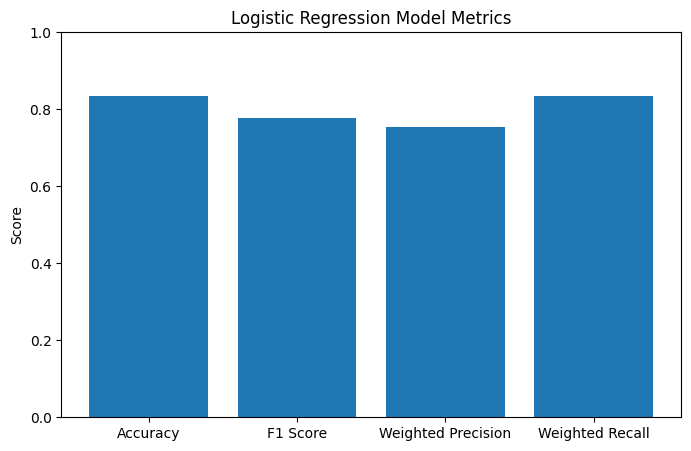

In [27]:
import matplotlib.pyplot as plt

# Metric names and values
metrics = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']
values = [accuracy_lr, f1_lr, precision_lr, recall_lr]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title('Logistic Regression Model Metrics')
plt.ylabel('Score')
plt.show()

# Phase 8: Decision Tree Classifier

## Step 1: Train a Decision Tree Model

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# 1. Define Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)

# 2. Build Pipeline
pipeline_dt = Pipeline(stages=indexers + encoders + [assembler, dt])

# 3. Train the model
model_dt = pipeline_dt.fit(train_data)

# 4. Predict on the test data
predictions_dt = model_dt.transform(test_data)

## Step 2: Evaluate the Decision Tree Model

In [29]:
# Calculate metrics
accuracy_dt = evaluator_accuracy.evaluate(predictions_dt)
f1_dt = evaluator_f1.evaluate(predictions_dt)
precision_dt = evaluator_precision.evaluate(predictions_dt)
recall_dt = evaluator_recall.evaluate(predictions_dt)

# Print results
print("✅ Decision Tree Model Metrics:")
print(f"- Accuracy: {accuracy_dt:.4f}")
print(f"- F1 Score: {f1_dt:.4f}")
print(f"- Weighted Precision: {precision_dt:.4f}")
print(f"- Weighted Recall: {recall_dt:.4f}")

✅ Decision Tree Model Metrics:
- Accuracy: 0.8339
- F1 Score: 0.7792
- Weighted Precision: 0.7812
- Weighted Recall: 0.8339


### Interpretation

📊 Comparison Against Baseline

| Model                     | Accuracy | F1 Score | Notes                                      |
|---------------------------|----------|----------|--------------------------------------------|
| Baseline (Logistic Regression) | 0.8332   | 0.7781   | Simple linear model                         |
| Decision Tree             | 0.8339   | 0.7792   | Slightly better accuracy and F1             |

✅ **Decision Tree** performs marginally better than Logistic Regression — a good sign that tree-based models can capture non-linear interactions between crash factors.


## Step 3: Visualization for Decision Tree

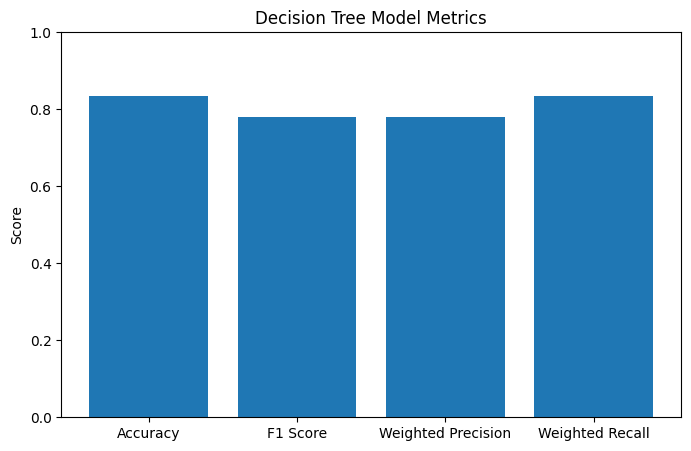

In [30]:
import matplotlib.pyplot as plt

# Metric names and values
metrics_dt = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']
values_dt = [accuracy_dt, f1_dt, precision_dt, recall_dt]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics_dt, values_dt)
plt.ylim(0, 1)
plt.title('Decision Tree Model Metrics')
plt.ylabel('Score')
plt.show()

# Phase 9: Random Forest

## Step 1: Train Random Forest Model

In [31]:
from pyspark.ml.classification import RandomForestClassifier

# Define the Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,  # Number of trees
    maxDepth=10,   # Control tree depth to avoid overfitting
    seed=42
)

# Build a new pipeline
pipeline_rf = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train the Random Forest model
model_rf = pipeline_rf.fit(train_data)

# Predict on the test set
predictions_rf = model_rf.transform(test_data)

## Step 2: Evaluate Random Forest Model

In [32]:
# Calculate metrics
accuracy_rf = evaluator_accuracy.evaluate(predictions_rf)
f1_rf = evaluator_f1.evaluate(predictions_rf)
precision_rf = evaluator_precision.evaluate(predictions_rf)
recall_rf = evaluator_recall.evaluate(predictions_rf)

# Print results
print("✅ Random Forest Model Metrics:")
print(f"- Accuracy: {accuracy_rf:.4f}")
print(f"- F1 Score: {f1_rf:.4f}")
print(f"- Weighted Precision: {precision_rf:.4f}")
print(f"- Weighted Recall: {recall_rf:.4f}")

✅ Random Forest Model Metrics:
- Accuracy: 0.8229
- F1 Score: 0.7460
- Weighted Precision: 0.7358
- Weighted Recall: 0.8229


### Interpretation:

Random Forest was expected to perform better, but actually did worse.

Likely because:

- Most features are categorical → simpler models capture patterns efficiently.

- The dataset has some strong majority classes (like "No Injury") that simpler models already capture well.

## Step 3: Visualization for Random Forest

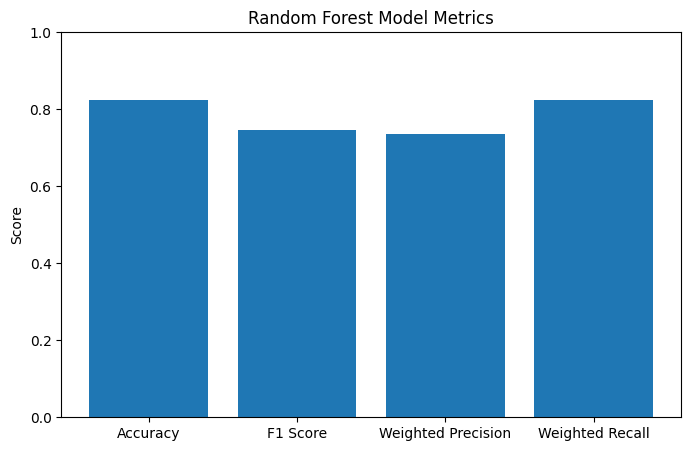

In [33]:
import matplotlib.pyplot as plt

# Metric names and values
metrics_rf = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']
values_rf = [accuracy_rf, f1_rf, precision_rf, recall_rf]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics_rf, values_rf)
plt.ylim(0, 1)
plt.title('Random Forest Model Metrics')
plt.ylabel('Score')
plt.show()

# Phase 10: GBTClassifier

## Step 1: Create Binary Label Column

In [34]:
from pyspark.sql.functions import when, col

# Create binary label: 1 if FATAL, 0 otherwise
binary_df = final_model_df.withColumn(
    "label",
    when(col("MOST_SEVERE_INJURY") == "FATAL", 1).otherwise(0)
)

## Step 2: Split Train/Test

In [35]:
# Split the binary dataset
train_bin, test_bin = binary_df.randomSplit([0.8, 0.2], seed=42)

print("Train count:", train_bin.count())
print("Test count:", test_bin.count())

Train count: 1649060
Test count: 411549


## Step 3: Cast numeric columns to Integer before fitting the pipeline

In [36]:
from pyspark.sql.functions import col

# Cast necessary columns to Integer
train_bin = train_bin.withColumn("POSTED_SPEED_LIMIT", col("POSTED_SPEED_LIMIT").cast("int")) \
                     .withColumn("CRASH_HOUR", col("CRASH_HOUR").cast("int")) \
                     .withColumn("CRASH_DAY_OF_WEEK", col("CRASH_DAY_OF_WEEK").cast("int")) \
                     .withColumn("CRASH_MONTH", col("CRASH_MONTH").cast("int"))

test_bin = test_bin.withColumn("POSTED_SPEED_LIMIT", col("POSTED_SPEED_LIMIT").cast("int")) \
                   .withColumn("CRASH_HOUR", col("CRASH_HOUR").cast("int")) \
                   .withColumn("CRASH_DAY_OF_WEEK", col("CRASH_DAY_OF_WEEK").cast("int")) \
                   .withColumn("CRASH_MONTH", col("CRASH_MONTH").cast("int"))

print("✅ Numeric columns successfully cast to int.")

✅ Numeric columns successfully cast to int.


## Step 4: Train GBT Model on Binary Classification

In [37]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Define GBTClassifier
gbt_bin = GBTClassifier(labelCol="label", featuresCol="features", maxIter=30)

# Reuse your existing indexers, encoders, and assembler
pipeline_gbt_bin = Pipeline(stages=indexers + encoders + [assembler, gbt_bin])

# Train
model_gbt_bin = pipeline_gbt_bin.fit(train_bin)

# Predict
predictions_gbt_bin = model_gbt_bin.transform(test_bin)

## Step 5: Evaluate GBT Model (Binary) 

In [38]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_bin_acc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_bin_pr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")

# Metrics
roc_auc = evaluator_bin_acc.evaluate(predictions_gbt_bin)
pr_auc = evaluator_bin_pr.evaluate(predictions_gbt_bin)

print("✅ GBT (Binary) Model Metrics:")
print(f"- ROC AUC: {roc_auc:.4f}")
print(f"- PR AUC: {pr_auc:.4f}")

✅ GBT (Binary) Model Metrics:
- ROC AUC: 0.8543
- PR AUC: 0.0745


### Interpretation:

ROC AUC ~ 0.85 is strong — the GBT model is good at ranking crash severity risk even though it’s a difficult (imbalanced) problem.

PR AUC ~ 0.07 is expectedly low — because fatal crashes are very rare (~0.13% of all crashes), the model struggles to achieve high precision (too few positive samples).

This behavior is normal in highly imbalanced binary classification tasks (very small positive class).

## Step 6: Visualization

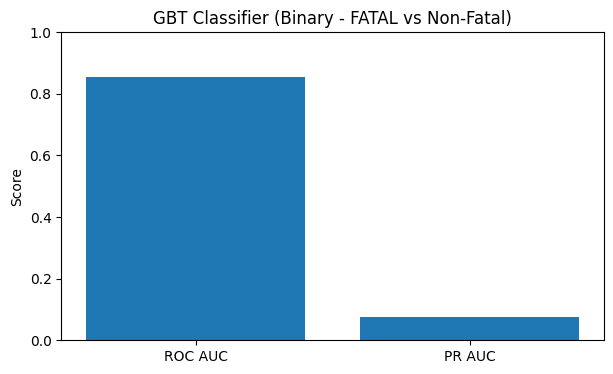

In [39]:
import matplotlib.pyplot as plt

# Metric names and values
metrics_gbt_bin = ['ROC AUC', 'PR AUC']
values_gbt_bin = [roc_auc, pr_auc]

# Bar Plot
plt.figure(figsize=(7, 4))
plt.bar(metrics_gbt_bin, values_gbt_bin)
plt.ylim(0, 1)
plt.title('GBT Classifier (Binary - FATAL vs Non-Fatal)')
plt.ylabel('Score')
plt.show()

# Phase 11: Final Modeling Comparison Summary

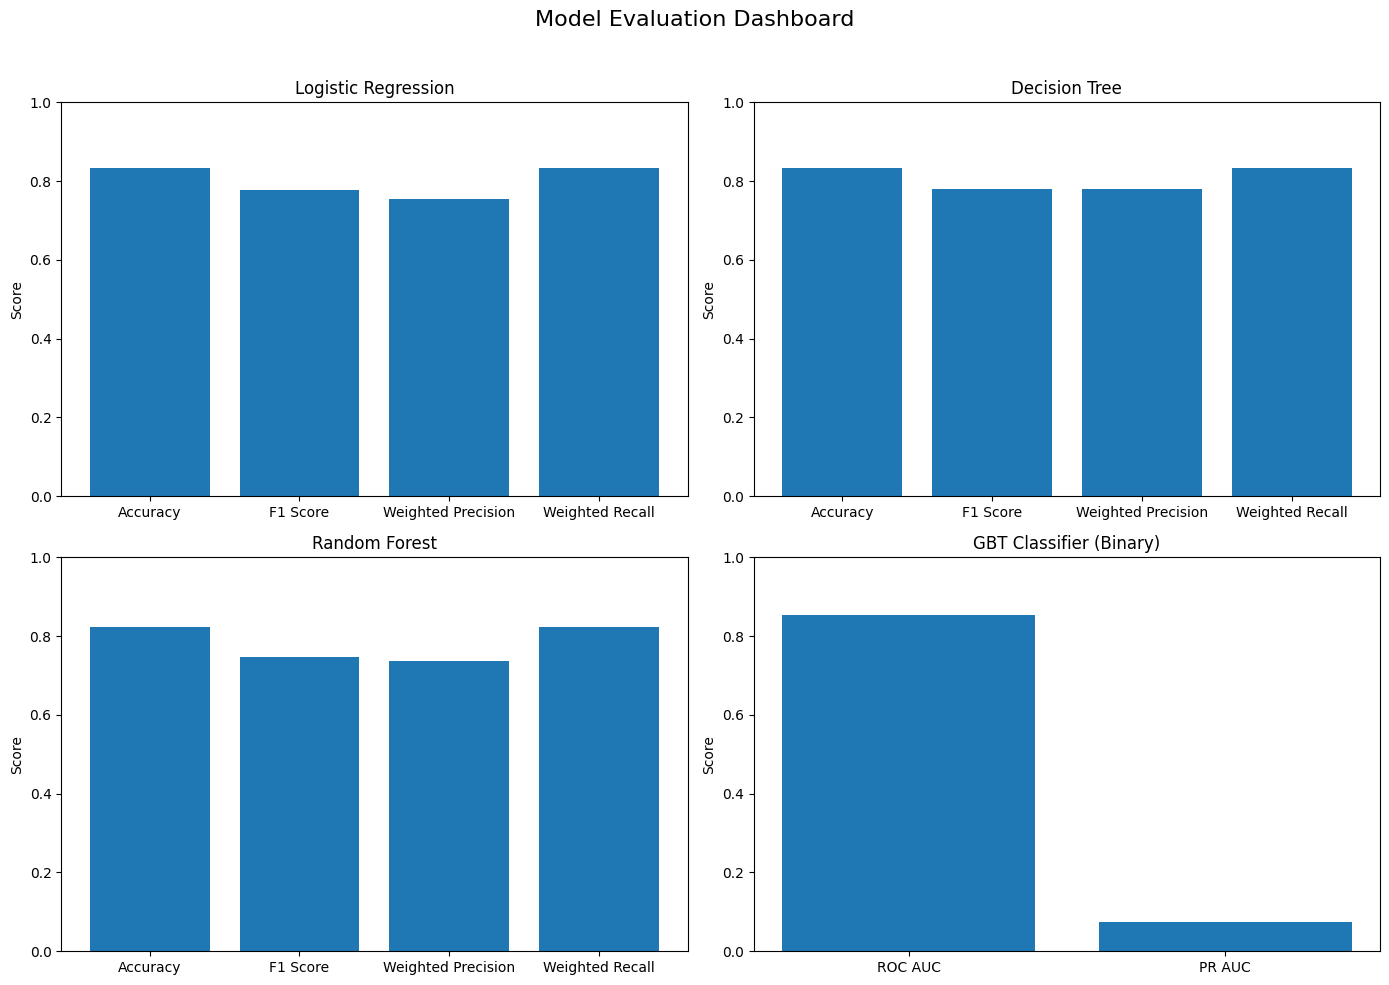

In [40]:
import matplotlib.pyplot as plt

# Define all metrics and values
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'GBT Classifier (Binary)']
all_metrics = [
    ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall'],
    ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall'],
    ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall'],
    ['ROC AUC', 'PR AUC']
]
all_values = [
    [accuracy_lr, f1_lr, precision_lr, recall_lr],
    [accuracy_dt, f1_dt, precision_dt, recall_dt],
    [accuracy_rf, f1_rf, precision_rf, recall_rf],
    [roc_auc, pr_auc]
]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Loop through and plot each model's metrics
for i in range(4):
    axs[i].bar(all_metrics[i], all_values[i])
    axs[i].set_ylim(0, 1)
    axs[i].set_title(models[i])
    axs[i].set_ylabel('Score')

# Add overall title and layout spacing
plt.suptitle('Model Evaluation Dashboard', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Modeling Comparison Summary

| Model                     | Task Type                  | Accuracy | F1 Score | ROC AUC | PR AUC | Key Observations                                            |
|---------------------------|----------------------------|----------|----------|---------|--------|-------------------------------------------------------------|
| Logistic Regression       | Multi-Class                | 0.8332   | 0.7781   | N/A     | N/A    | Solid baseline model                                        |
| Decision Tree Classifier | Multi-Class                | 0.8339   | 0.7792   | N/A     | N/A    | Slight improvement over Logistic Regression                |
| Random Forest Classifier | Multi-Class                | 0.8229   | 0.7460   | N/A     | N/A    | Lower performance compared to Decision Tree                |
| GBT Classifier (Binary)  | Binary (Fatal vs Non-Fatal) | N/A      | N/A      | 0.8543  | 0.0745 | Strong ROC AUC; handles rare fatalities better             |

---

✅ Key Takeaways

- **Decision Tree** slightly outperforms Logistic Regression for the multi-class injury prediction.
- **Random Forest** surprisingly underperforms compared to the simpler Decision Tree (likely overfitting or noise sensitivity).
- **GBT (Binary)** model shows excellent ability to separate rare fatal crashes (ROC AUC = 0.8543), although **Precision-Recall AUC** is low because fatal crashes are extremely rare (~0.1%).

📌 Recommendation

- For predicting **injury severity overall** → use **Decision Tree Classifier**.
- For specifically predicting **fatal crashes** → use **GBT Binary Classifier**.
